In [1]:
%matplotlib inline

import urllib
import os
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import movingpandas as mpd
import datatable as dt
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.pandas
import folium
import tensorflow as tf

from folium.plugins import HeatMap
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
from datetime import datetime, timedelta
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from holoviews import opts
from sklearn.preprocessing import StandardScaler
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))

import warnings
warnings.simplefilter("ignore")
CRS_METRIC = from_epsg(4326)

In [78]:
def create_datasets(df, lookback, target_size, single_step):
    # normalize the input
    input_data = df.iloc[:, [0, 1]].values

    X = []
    y = []
    start_index = lookback
    end_index = len(input_data) - target_size
    for i in range(start_index, end_index):
        indices = range(i-lookback, i)
        X.append(input_data[indices])
        if single_step:
            y.append(input_data[i + target_size - 1, :])
        else:
            y.append(input_data[i:i + target_size, :].reshape(target_size*2))
    return X, y

def merge_with_mmsi(data, df):
    df_data = pd.DataFrame(data)
    df_data['mmsi'] = df.reset_index()['mmsi']

    return df_data

def generate_all_datasets(df, history_size, target_size, single_step):
    X = []
    y = []

    idx_list = df['mmsi'].value_counts().index.tolist()

    for mmsi in idx_list:
        data_temp = df.loc[df['mmsi'] == mmsi]
        X_temp, y_temp = create_datasets(data_temp, history_size, target_size, single_step)
        X.extend(X_temp)
        y.extend(y_temp)
    return np.array(X), np.array(y)

def create_test_set(df, past_history, future_target):
    uni_values = df.iloc[:, [2, 3]].values
    
    train_size_temp = int(len(uni_values) * 0.8)
    test_size = len(uni_values) - train_size_temp
    valid_size = int(train_size_temp * 0.25)
    train_size = train_size_temp - valid_size

    train_temp, test = uni_values[:train_size_temp, :], uni_values[train_size_temp:len(uni_values), :]
    train, valid = train_temp[:train_size, :], train_temp[train_size:train_size_temp, :]

    df_train_temp, df_test = df[:train_size_temp], df[train_size_temp:len(uni_values)]
    df_train, df_valid = df[:train_size], df[train_size:train_size_temp]

    sc_train = StandardScaler().fit(train)
    train_norm = sc_train.transform(train)
    valid_norm = sc_train.transform(valid)
    test_norm = sc_train.transform(test)

    # create datasets
#     data_test = merge_with_mmsi(test_norm, df_test)
    data_test = merge_with_mmsi(train_norm, df_train)
    
    x_test_single, y_test_single = generate_all_datasets(data_test, past_history, future_target, False)
    print('\nX test shape: {}, y test shape: {} '.format(x_test_single.shape, y_test_single.shape))
    return x_test_single, y_test_single, sc_train

def inverse_to_df(data, scaler):
    data_inverse = scaler.inverse_transform(data)
    df_data = pd.DataFrame(data_inverse)
    df_data.rename(columns={0:'lon', 1:'lat'}, inplace=True)    
    return df_data

def generateBaseMap(default_location=[1.22437, 103.78520], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

def plotDot(rows, index, color, m):
    folium.Marker([rows.lat, rows.lon], radius=10, icon=folium.Icon(color=color), tooltip=index).add_to(m)
    return m

def showMap(df, m, color):
    for index, rows in df.iterrows():
        m = plotDot(rows, index, color, m)
    return m

def plot_predict(target, pred, history):
    themap = generateBaseMap()
    m = showMap(history, themap, 'blue')
    m = showMap(target, m, 'red')
    m = showMap(pred, m, 'green')
    return m

def show_traj(idx):
    return plot_predict(inverse_to_df(y_test[idx], scaler), 
                        inverse_to_df(prediction[idx], scaler), 
                        inverse_to_df(x_test[idx], scaler))

def recurrent_predict(x_test, idx, lookback, target):
    steps, feats = x_test.shape[-2:]
    inp = x_test[idx].reshape(1, steps, feats)
    preds = []

    end_index = 30//target

    for i in range(0, end_index):
        inp = inp.reshape(1,steps,feats)
        pred = model.predict(inp).reshape(target, 2)
        preds.extend(pred.tolist())
        inp = inp.reshape(steps,feats).tolist()
        if i == end_index-1:
            break
        if ((i+1)*10 == lookback):
            inp = pred
    #         else:
        inp = np.append(inp[(i+1)*target:lookback], preds, axis=0)
    return preds

def generate_targets(idx, lookback, target):
    targets = []
    end_index = 30//target

    for i in range(1, end_index+1):
        temp = y_test[idx+(i-1)*target]
        targets.extend(temp)
    return targets

def show_traj_recc(idx, lookback, target):
    return plot_predict(inverse_to_df(generate_targets(idx, lookback, target), scaler), 
                        inverse_to_df(recurrent_predict(x_test, idx, lookback, target), scaler), 
                        inverse_to_df(x_test[idx], scaler))

In [5]:
df = pd.read_csv('final_dataset_spline.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print('finished reading {} records'.format(len(df)))
df.head()

finished reading 2508510 records


time       mmsi         lon       lat
0  2019-12-01 00:22:00  205408000  103.538453  1.181110
1  2019-12-01 00:23:00  205408000  103.540066  1.181498
2  2019-12-01 00:24:00  205408000  103.541561  1.181921
3  2019-12-01 00:25:00  205408000  103.542941  1.182378
4  2019-12-01 00:26:00  205408000  103.544213  1.182869

In [79]:
x_test, y_test, scaler = create_test_set(df, 10, 10)


X test shape: (1464866, 10, 2), y test shape: (1464866, 20) 


In [81]:
test = y_test.reshape(-1, 10*2)

(array([1.46000e+02, 1.10400e+03, 5.05300e+03, 2.46410e+04, 3.75810e+04,
        1.39889e+05, 2.26267e+05, 4.82970e+04, 2.83800e+03, 1.36000e+02]),
 array([-4.74226753, -3.93172784, -3.12118815, -2.31064846, -1.50010876,
        -0.68956907,  0.12097062,  0.93151032,  1.74205001,  2.5525897 ,
         3.3631294 ]),
 <a list of 10 Patch objects>)

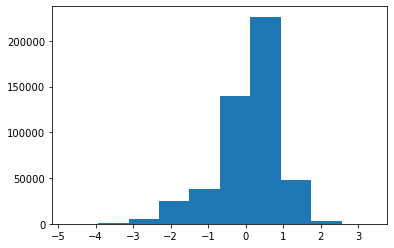

In [61]:
plt.hist(test[:,0])

(array([1.30000e+01, 3.43500e+03, 5.31900e+03, 2.25520e+04, 7.62010e+04,
        1.59133e+05, 1.41577e+05, 7.74150e+04, 2.81000e+02, 2.60000e+01]),
 array([-4.94335292, -4.09622526, -3.24909761, -2.40196995, -1.55484229,
        -0.70771463,  0.13941302,  0.98654068,  1.83366834,  2.680796  ,
         3.52792366]),
 <a list of 10 Patch objects>)

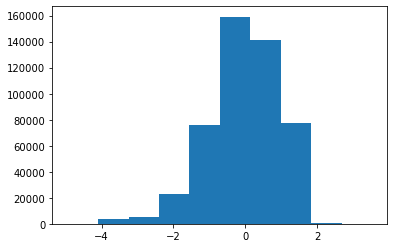

In [80]:
plt.hist(test[:,1])

(array([4.05000e+02, 5.30000e+03, 2.38790e+04, 1.08697e+05, 1.75743e+05,
        4.49057e+05, 6.02656e+05, 9.08480e+04, 8.10400e+03, 1.77000e+02]),
 array([-5.07203926, -4.18512958, -3.2982199 , -2.41131022, -1.52440054,
        -0.63749086,  0.24941881,  1.13632849,  2.02323817,  2.91014785,
         3.79705753]),
 <a list of 10 Patch objects>)

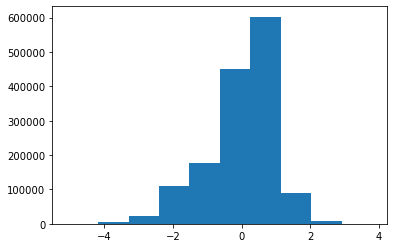

In [82]:
plt.hist(test[:,0])

In [77]:
test[:,0][(test[:,0] < 0.00001) & (test[:,0] > -0.00001)]

array([ 9.90582929e-06,  3.79545923e-06, -1.67090846e-06, -3.38615991e-06,
        5.74433500e-06])

In [7]:
def load_model_history(model, history):
    model = tf.keras.models.load_model(model)
    history = np.load(history, allow_pickle=True).item()
    return model, history

In [8]:
def plot_loss(history, model, param='loss'):
    loss = history[param]
    val_loss = history['val_'+param]

    epochs = range(len(loss))

    plt.clf()
    plt.plot(epochs, loss, 'b', label='Training '+param)
    plt.plot(epochs, val_loss, 'r', label='Validation '+param)
    plt.title('Training and validation '+param)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [19]:
def load_and_plot(name, hist, future):
    x, y, scaler = create_test_set(df, hist, future)
    model, history = load_model_history(name+'.hdf5', name+'.npy')
    plot_loss(history, model, 'mape')
    plot_loss(history, model)
    test_loss = model.evaluate(x, y, batch_size=256)
    print('test loss :', test_loss)
    return model, x, y, scaler

### Plot training loss

Window Size = 30; Target = 1

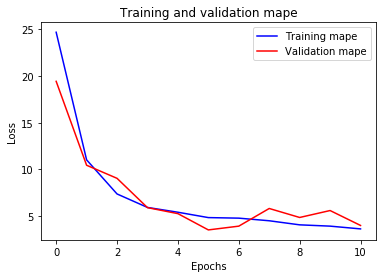

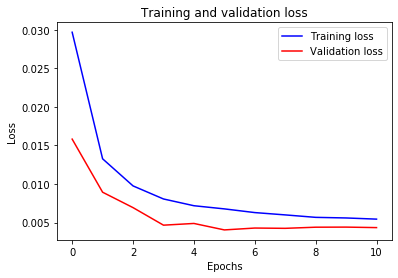

490677/490677 [==============================] - 24s 49us/sample - loss: 0.0054 - mape: 7.3435
test loss : [0.005365686923900582, 7.343526]


In [11]:
load_and_plot('spline_multi_step_1_20_3lstm_32')

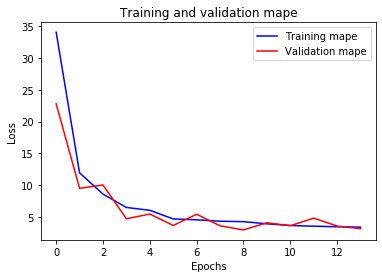

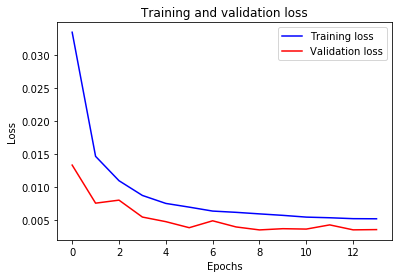

495927/495927 [==============================] - 14s 28us/sample - loss: 0.0043 - mape: 3.7138
test loss : [0.004309533568641269, 3.7137542]


In [13]:
load_and_plot('spline_multi_step_1_10_3lstm_32')

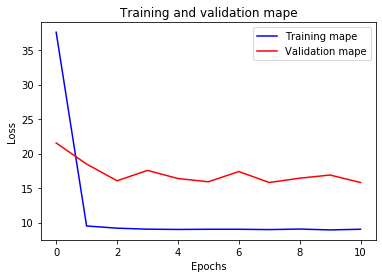

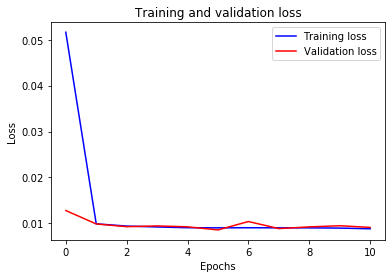

500652/500652 [==============================] - 4s 7us/sample - loss: 0.0115 - mape: 12.3292
test loss : [0.011513030003173903, 12.329219]


In [15]:
load_and_plot('spline_multi_step_1_1_3lstm_32')

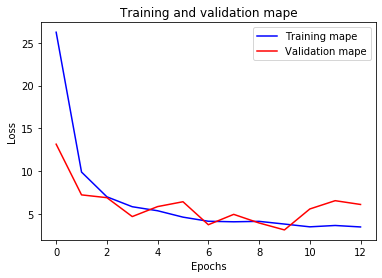

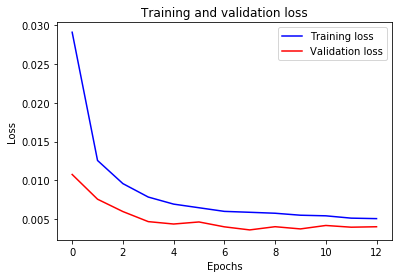

485427/485427 [==============================] - 36s 74us/sample - loss: 0.0050 - mape: 3.4246
test loss : [0.004961216178579856, 3.424587]


In [18]:
model = load_and_plot('spline_multi_step_1_30_3lstm_32')

In [19]:
prediction = model.predict(x_test)

In [20]:
samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)

In [21]:
y_test = y_test.reshape(samples, size//2, 2)

In [22]:
prediction.shape, y_test.shape

((485427, 1, 2), (485427, 1, 2))

In [107]:
show_traj(19915)

In [54]:
show_traj_recc(19905, 20, 10)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Window size = 30; Target = 10


X test shape: (480736, 30, 2), y test shape: (480736, 20) 


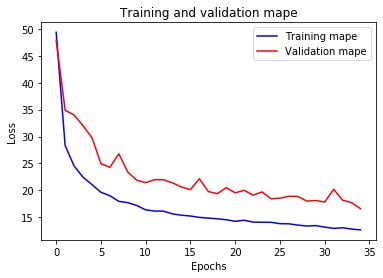

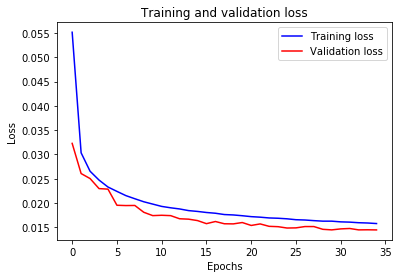

480736/480736 [==============================] - 37s 78us/sample - loss: 0.0182 - mape: 87.5715
test loss : [0.01818010808579742, 87.571465]


In [16]:
model = load_and_plot('spline_multi_step_10_30_3lstm_32', 30, 10)


X test shape: (485952, 20, 2), y test shape: (485952, 20) 


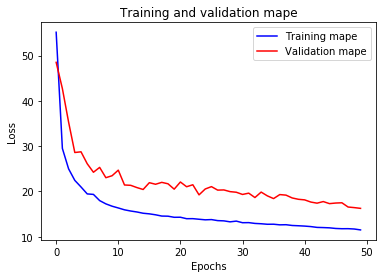

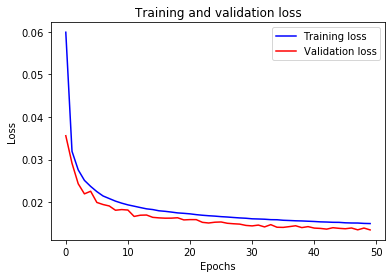

485952/485952 [==============================] - 29s 60us/sample - loss: 0.0170 - mape: 103.0824
test loss : [0.016981031379760456, 103.08238]


In [20]:
model, x_test, y_test, scaler = load_and_plot('spline_multi_step_10_20_3lstm_32', 20, 10)

In [21]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [52]:
show_traj(50000)

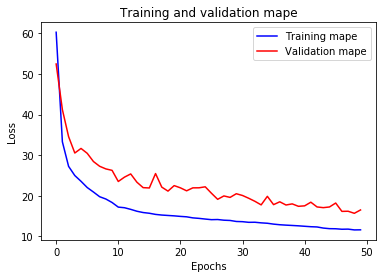

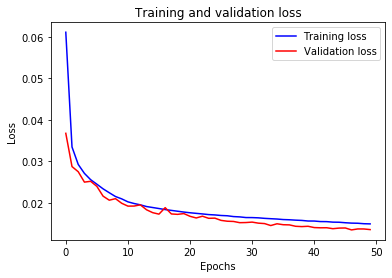

491202/491202 [==============================] - 16s 33us/sample - loss: 0.0170 - mape: 29.4649
test loss : [0.01698013825818101, 29.46488]


In [11]:
load_and_plot('spline_multi_step_10_10_3lstm_32')

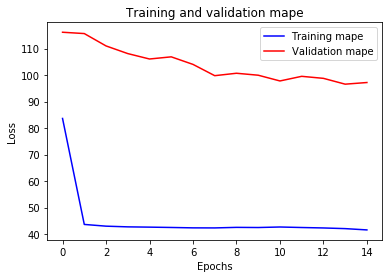

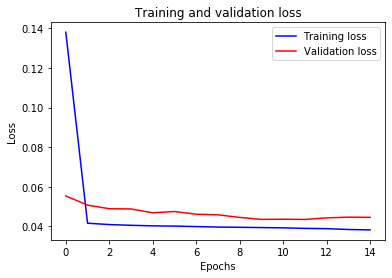

495927/495927 [==============================] - 4s 8us/sample - loss: 0.0590 - mape: 70.4758
test loss : [0.059035068598454386, 70.47578]


In [91]:
load_and_plot('spline_multi_step_10_1_3lstm_32')

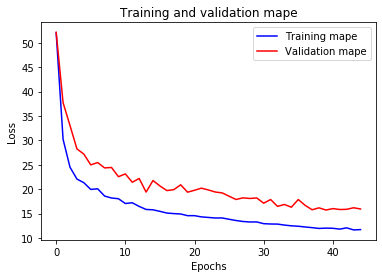

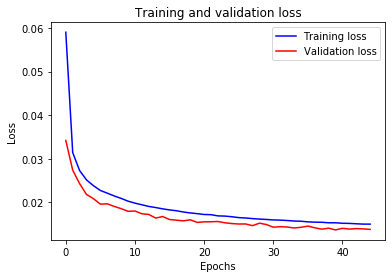

475645/475645 [==============================] - 48s 101us/sample - loss: 0.0173 - mape: 58.5953
test loss : [0.017305533780494094, 58.595306]


In [93]:
load_and_plot('spline_multi_step_10_40_3lstm_32')

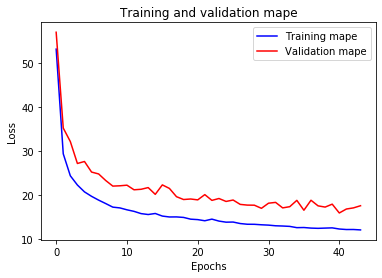

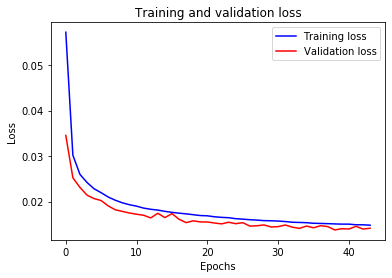

465871/465871 [==============================] - 64s 137us/sample - loss: 0.0173 - mape: 77.2217
test loss : [0.01729905181268134, 77.2217]


In [95]:
load_and_plot('spline_multi_step_10_60_3lstm_32')

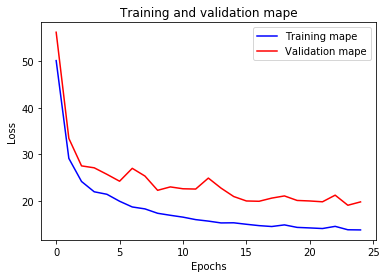

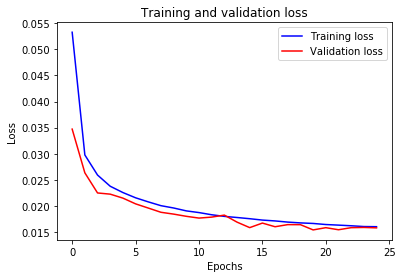

456715/456715 [==============================] - 86s 188us/sample - loss: 0.0196 - mape: 14.0292
test loss : [0.019562406459095856, 14.029232]


In [98]:
model = load_and_plot('spline_multi_step_10_80_3lstm_32')

In [100]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [108]:
show_traj(19820)

In [106]:
show_traj_recc(19905, 80, 10)

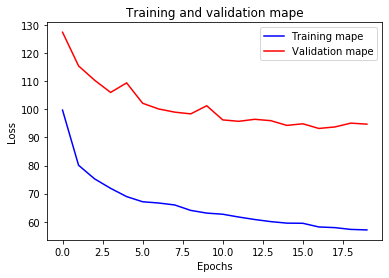

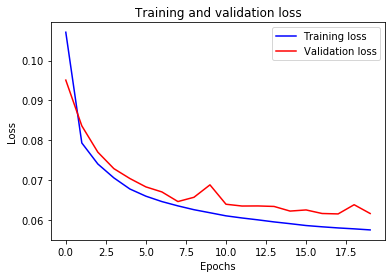

470674/470674 [==============================] - 36s 77us/sample - loss: 0.0750 - mape: 67.6510
test loss : [0.0749964642757579, 67.650986]


In [599]:
model = load_and_plot('multi_step_30_30_3lstm')

In [600]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [612]:
show_traj(2030)

In [613]:
show_traj(19905)

In [614]:
show_traj(19800)

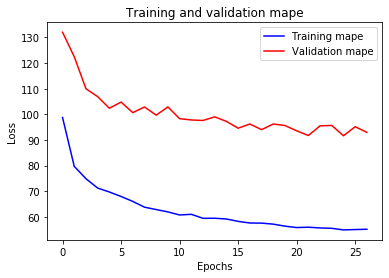

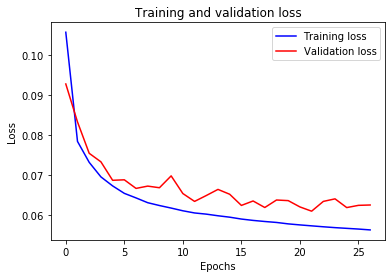

465871/465871 [==============================] - 47s 100us/sample - loss: 0.0759 - mape: 69.2851
test loss : [0.07592277208286298, 69.28507]


In [590]:
model = load_and_plot('retry30_multi_step_40_30_3lstm_32')

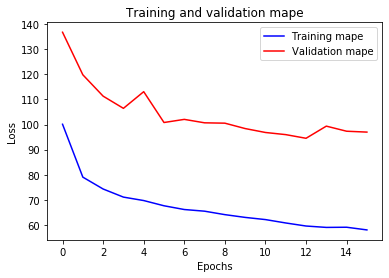

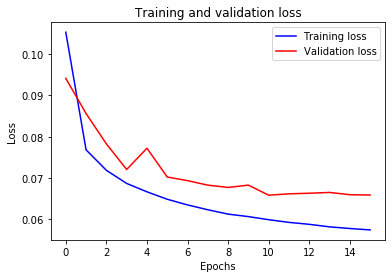

456715/456715 [==============================] - 68s 148us/sample - loss: 0.0792 - mape: 71.1885
test loss : [0.07920562829716876, 71.18848]


In [592]:
model = load_and_plot('retry30_multi_step_60_30_3lstm_32')

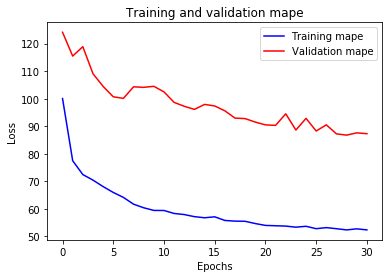

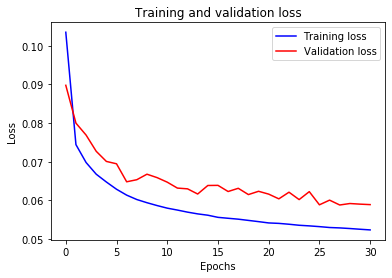

448218/448218 [==============================] - 78s 174us/sample - loss: 0.0713 - mape: 65.3839
test loss : [0.07129171330742527, 65.38389]


In [594]:
model = load_and_plot('retry30_multi_step_80_30_3lstm_32')

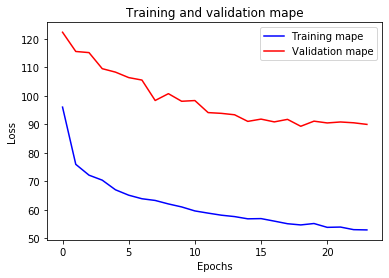

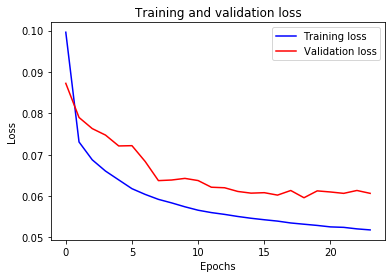

440311/440311 [==============================] - 99s 224us/sample - loss: 0.0730 - mape: 67.0496
test loss : [0.0729752507923264, 67.04961]


In [596]:
model = load_and_plot('retry30_multi_step_100_30_3lstm_32')

In [ ]:
model = load_and_plot('retr')

In [556]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [557]:
show_traj(19925)

In [582]:
show_traj_recc(19925, 10, 10)

ValueError: operands could not be broadcast together with shapes (180,) (2,) (180,) 

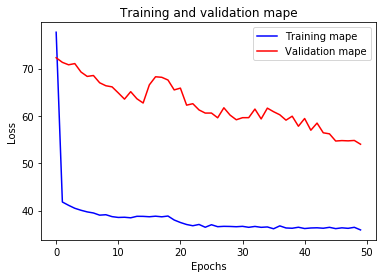

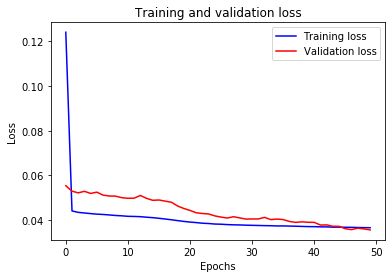

495927/495927 [==============================] - 4s 7us/sample - loss: 0.0463 - mape: 41.1538
test loss : [0.046290190147889036, 41.153793]


In [363]:
load_and_plot('retry_multi_step_1_10_3lstm_32')

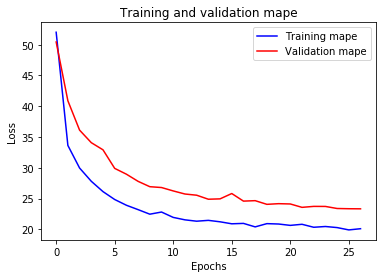

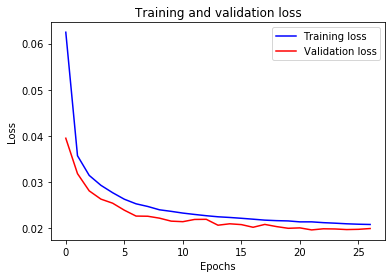

475645/475645 [==============================] - 49s 102us/sample - loss: 0.0238 - mape: 20.0455
test loss : [0.02383531584816386, 20.045475]


In [365]:
load_and_plot('retry_multi_step_40_10_3lstm_32')

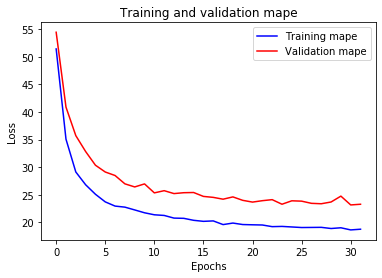

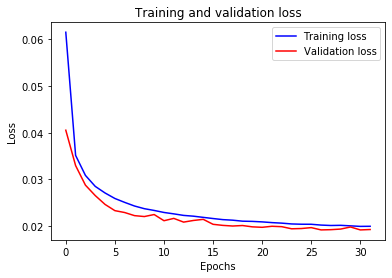

465871/465871 [==============================] - 63s 135us/sample - loss: 0.0229 - mape: 19.9757
test loss : [0.02289272992549269, 19.975716]


In [367]:
load_and_plot('retry_multi_step_60_10_3lstm_32')

In [37]:
prediction = model.predict(x_test)

In [72]:
prediction[0], y_test[0]

(array([0.9535373, 0.5244273], dtype=float32), array([0.95343443, 0.52715185]))

In [67]:
x_0 = inverse_to_df(x_test[0], scaler)

In [345]:
show_traj(2037)

In [212]:
prediction[2030:2030+1]
# inverse_to_df(prediction[2030:2030+1], scaler)

array([[0.62654054, 0.5384747 ]], dtype=float32)

In [352]:
show_traj_recc(42323)